# STA LTA for BSPF only

## Import Libraries

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy.signal.trigger import coincidence_trigger

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

config['seeds'] = {"rotation":"PY.BSPF..HJ*", "translation1":"II.PFO.10.BH*", "translation2":"PY.PFOIX..HH*"}

# config['tbeg'] = obs.UTCDateTime("2022-10-03 16:00:00")
# config['tend'] = obs.UTCDateTime("2022-10-03 20:00:00")

# config['tbeg'] = obs.UTCDateTime("2022-10-28 12:00:00")
# config['tend'] = obs.UTCDateTime("2022-10-28 16:00:00")

# config['tbeg'] = obs.UTCDateTime("2022-12-31 11:00:00")
# config['tend'] = obs.UTCDateTime("2022-12-31 15:00:00")

# config['tbeg'] = obs.UTCDateTime("2023-04-02 16:00:00")
# config['tend'] = obs.UTCDateTime("2023-04-02 17:00:00")

config['tbeg'] = obs.UTCDateTime("2022-12-31 00:00:00")
config['tend'] = obs.UTCDateTime("2022-12-31 23:00:00")

config['output_path'] = data_path+"BSPF/data/"

config['client'] = Client("IRIS")

## Load Data

In [4]:
from functions.request_data import __request_data

In [18]:
# st_bspf, inv_bspf = __request_data(config['seeds']['rotation'], config['tbeg'], config['tend'])
st_bspf = obs.read("./20221231_entire_day.mseed")

In [12]:
# st_bspf.write("./20221231_entire_day.mseed", format="MSEED")

/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [6]:
st_bspf

6 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-31T12:40:14.818700Z - 2022-12-31T22:59:59.998700Z | 200.0 Hz, 7437037 samples
PY.BSPF..HJN | 2022-12-31T12:40:14.818700Z - 2022-12-31T22:59:59.998700Z | 200.0 Hz, 7437037 samples
PY.BSPF..HJE | 2022-12-31T12:40:14.818700Z - 2022-12-31T22:59:59.998700Z | 200.0 Hz, 7437037 samples
PY.BSPF..HJZ | 2022-12-30T23:59:59.998800Z - 2022-12-31T12:40:12.803800Z | 200.0 Hz, 9122562 samples
PY.BSPF..HJN | 2022-12-30T23:59:59.998800Z - 2022-12-31T12:40:12.803800Z | 200.0 Hz, 9122562 samples
PY.BSPF..HJE | 2022-12-30T23:59:59.998800Z - 2022-12-31T12:40:12.803800Z | 200.0 Hz, 9122562 samples

In [7]:
st_bspf = st_bspf.detrend("linear")

if len(st_bspf) > 3:
    st_bspf = st_bspf.merge(fill_value=0)

In [8]:
st_bspf

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-12-30T23:59:59.998800Z - 2022-12-31T22:59:59.998800Z | 200.0 Hz, 16560001 samples
PY.BSPF..HJN | 2022-12-30T23:59:59.998800Z - 2022-12-31T22:59:59.998800Z | 200.0 Hz, 16560001 samples
PY.BSPF..HJZ | 2022-12-30T23:59:59.998800Z - 2022-12-31T22:59:59.998800Z | 200.0 Hz, 16560001 samples

## Launch Trigger

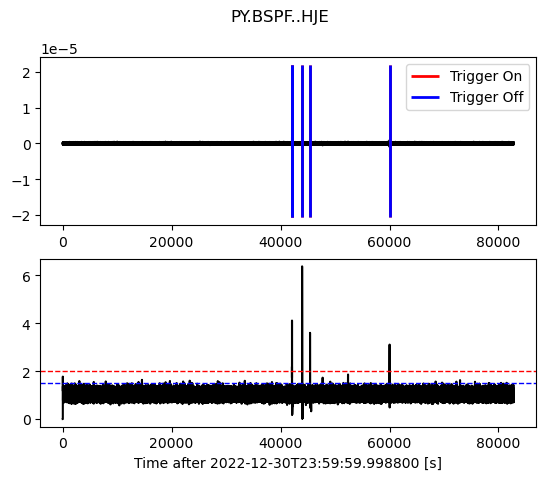

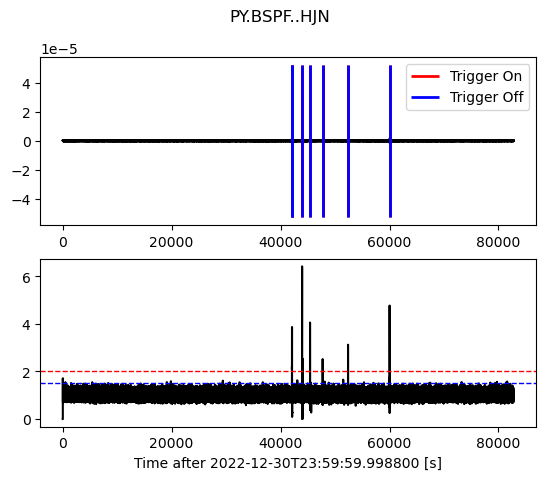

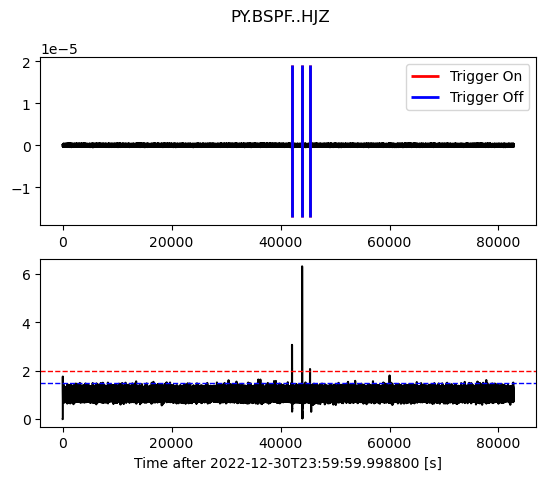

In [17]:
from obspy.signal.trigger import recursive_sta_lta, trigger_onset, plot_trigger
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint

st = st_bspf.copy()

st = st.sort()

# st = st.detrend("simple")
# st = st.taper(0.1)
# st = st.filter("highpass", freq=0.01, corners=4, zerophase=True)
st = st.filter("bandpass", freqmin=1.0, freqmax=18.0, corners=4, zerophase=True)


# st = st.normalize(global_max=True)

df = st[0].stats.sampling_rate

config['trigger_type'] = 'recstalta'
config['thr_on'] = 2.0  # 2.0   ## thr_on (float) – threshold for switching single station trigger on
config['thr_off'] = 1.5 # 1.2   ## thr_off (float) – threshold for switching single station trigger off
config['lta'] = 10  # 10   ## seconds
config['sta'] = 1.5 # 1.5   ## seconds
config['thr_coincidence_sum'] = 1
# config['similarity_thresholds'] = {"BSPF": 0.5, "PFO": 0.5}


for ii, tr in enumerate(st):

    cft = recursive_sta_lta(tr.data, int(config['sta']*df), int(config['lta']*df))

    on_off = trigger_onset(cft, config['thr_on'], config['thr_off'])

    plot_trigger(tr, cft, config['thr_on'], config['thr_off'])

In [10]:
st.merge()
pprint(config)

trig = coincidence_trigger(config['trigger_type'],
                           config['thr_on'],
                           config['thr_off'],
                           stream = st,
                           thr_coincidence_sum = config['thr_coincidence_sum'],
                           sta=config['sta'],
                           lta=config['lta'],
#                            similarity_threshold=config['similarity_thresholds'],
                          )

pprint(trig), len(trig)

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-12-30T23:59:59.998800Z - 2022-12-31T22:59:59.998800Z | 200.0 Hz, 16560001 samples
PY.BSPF..HJN | 2022-12-30T23:59:59.998800Z - 2022-12-31T22:59:59.998800Z | 200.0 Hz, 16560001 samples
PY.BSPF..HJZ | 2022-12-30T23:59:59.998800Z - 2022-12-31T22:59:59.998800Z | 200.0 Hz, 16560001 samples

{'client': <obspy.clients.fdsn.client.Client object at 0x7f10006873a0>,
 'lta': 10,
 'output_path': '/import/kilauea-data/BSPF/data/',
 'seeds': {'rotation': 'PY.BSPF..HJ*',
           'translation1': 'II.PFO.10.BH*',
           'translation2': 'PY.PFOIX..HH*'},
 'sta': 1.5,
 'tbeg': UTCDateTime(2022, 12, 31, 0, 0),
 'tend': UTCDateTime(2022, 12, 31, 23, 0),
 'thr_coincidence_sum': 1,
 'thr_off': 1.5,
 'thr_on': 2.0,
 'trigger_type': 'recstalta'}
[{'coincidence_sum': 2.0,
  'duration': 9.829999923706055,
  'similarity': {},
  'stations': ['BSPF', 'BSPF'],
  'time': UTCDateTime(2022, 12, 31, 11, 41, 25, 383800),
  'trace_ids': ['PY.BSPF..HJN', 'PY.BSPF..HJE']},
 {'coincidence_sum': 3.0,
  'duration': 5.614999771118164,
  'similarity': {},
  'stations': ['BSPF', 'BSPF', 'BSPF'],
  'time': UTCDateTime(2022, 12, 31, 11, 41, 36, 63800),
  'trace_ids': ['PY.BSPF..HJZ', 'PY.BSPF..HJN', 'PY.BSPF..HJE']},
 {'coincidence_sum': 3.0,
  'duration': 8.175000190734863,
  'similarity': {},
  'stations

(None, 7)

In [11]:
# fig, ax = plt.subplots(3,1)

# for i, tr in enumerate(st):
#     ax[i].plot(tr.times(), tr.data, 'k', zorder=2)

#     ttt = tl['time']-tr.stats.starttime
#     for tl in trig:
#         ax[i].axvline(ttt, color='r', zorder=5)
#         ax[i].axvline(ttt+tl['duration'], color='b', zorder=5)

#     ax[i].set_ylim(-5e-6, 5e-6)
